# Twitter Ratio

This folder contains data behind the story [The Worst Tweeter In Politics Isn’t Trump](https://fivethirtyeight.com/features/the-worst-tweeter-in-politics-isnt-trump/).

`senators.csv` contains tweets from all senators collected on Oct. 19 and 20.

`BarackObama.csv` contains tweets from [@BarackObama](https://twitter.com/BarackObama) collected on Oct. 20.

`realDonaldTrump.csv` contains tweets from [@realDonaldTrump](https://twitter.com/realDonaldTrump) collected on Oct. 23.

## Senator Tweets

We'll start of by looking at the `senators.csv` dataset.

In [1]:
# The usual suspects ...
import logging
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cleaner2 as clr

# And their accomplices ...
from gensim import corpora
from gensim import models
from gensim import similarities
from nltk.corpus import stopwords
from nltk.tokenize import wordpunct_tokenize
from collections import defaultdict

# Settings
sns.set(context='notebook', style='whitegrid', palette='deep', rc=None)
#logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [2]:
# Reading in the data
tweets = pd.read_csv('senators.csv', encoding="ISO-8859-1")
tweets.shape

(288615, 10)

In [3]:
# Top 5 rows
tweets.head()

,created_at,text,url,replies,retweets,favorites,user,bioguide_id,party,state
0,10/19/17 21:47,We released bipartisan healthcare bill today &...,https://twitter.com/amyklobuchar/status/921130...,21,129,533,amyklobuchar,K000367,D,MN
1,10/19/17 18:48,I spoke with @Morning_Joe team abt #HonestAds ...,https://twitter.com/amyklobuchar/status/921085...,8,46,150,amyklobuchar,K000367,D,MN
2,10/19/17 18:14,Lots of interest in my bill with Senators Warn...,https://twitter.com/amyklobuchar/status/921077...,36,227,932,amyklobuchar,K000367,D,MN
3,10/19/17 18:04,"Today's the day @MarkWarner, @SenJohnMcCain &a...",https://twitter.com/amyklobuchar/status/921074...,17,167,550,amyklobuchar,K000367,D,MN
4,10/19/17 16:33,".@MarkWarner, @SenJohnMcCain &amp; I put toget...",https://twitter.com/amyklobuchar/status/921051...,31,279,893,amyklobuchar,K000367,D,MN


### Exploration

In [4]:
tweets.dtypes

created_at     object
text           object
url            object
replies         int64
retweets        int64
favorites       int64
user           object
bioguide_id    object
party          object
state          object
dtype: object

Text(0,0.5,'Density')

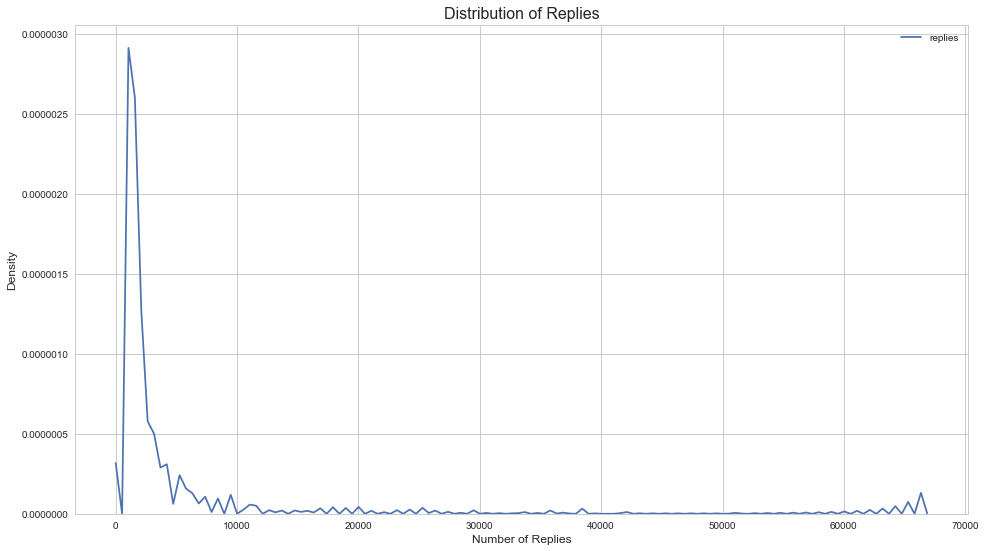

In [5]:
# Distribution of replies
plt.figure(figsize=(16, 9))
sns.kdeplot(tweets.replies)
plt.title('Distribution of Replies', fontsize=16)
plt.xlabel('Number of Replies', fontsize=12)
plt.ylabel('Density', fontsize=12)

Text(0,0.5,'Density')

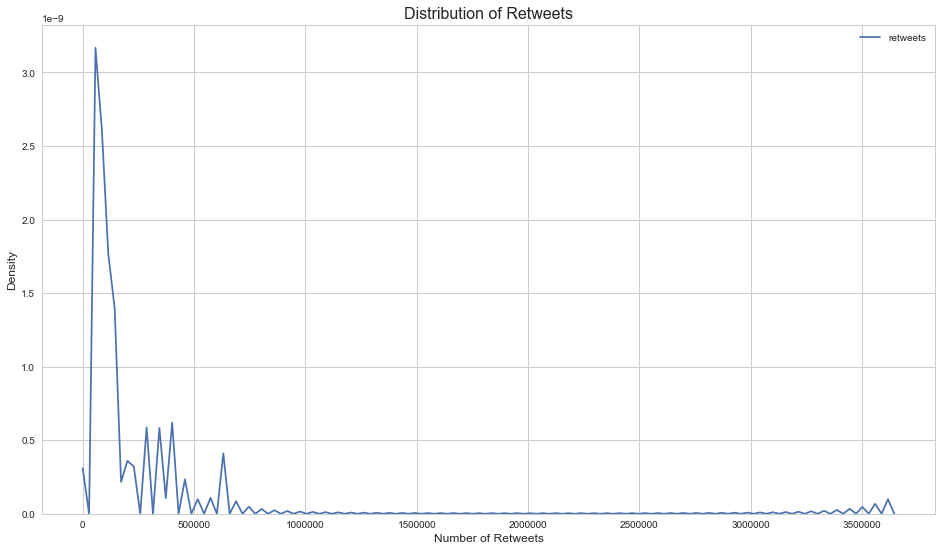

In [6]:
# Distribution of retweets
plt.figure(figsize=(16, 9))
sns.kdeplot(tweets.retweets)
plt.title('Distribution of Retweets', fontsize=16)
plt.xlabel('Number of Retweets', fontsize=12)
plt.ylabel('Density', fontsize=12)

Text(0,0.5,'Density')

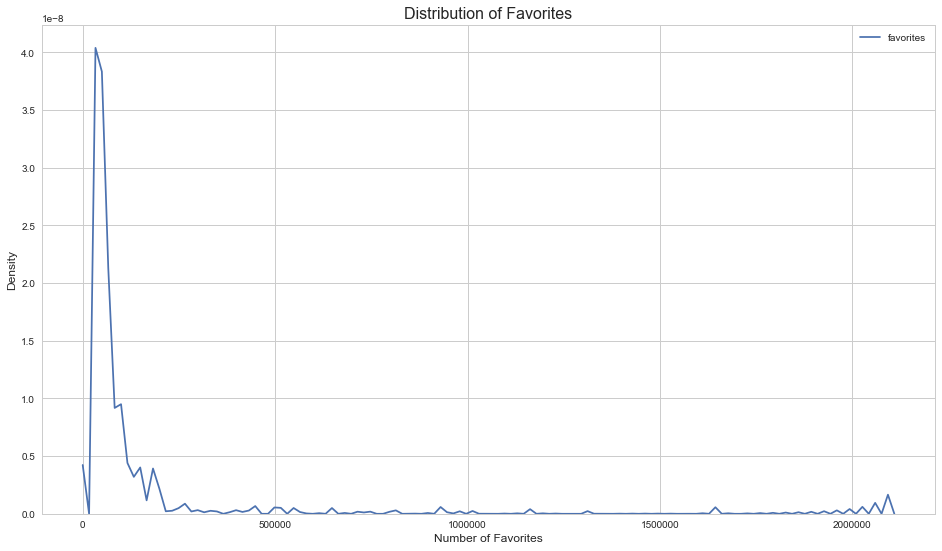

In [7]:
# Distribution of favourites
plt.figure(figsize=(16, 9))
sns.kdeplot(tweets.favorites)
plt.title('Distribution of Favorites', fontsize=16)
plt.xlabel('Number of Favorites', fontsize=12)
plt.ylabel('Density', fontsize=12)

Text(0,0.5,'Retweets')

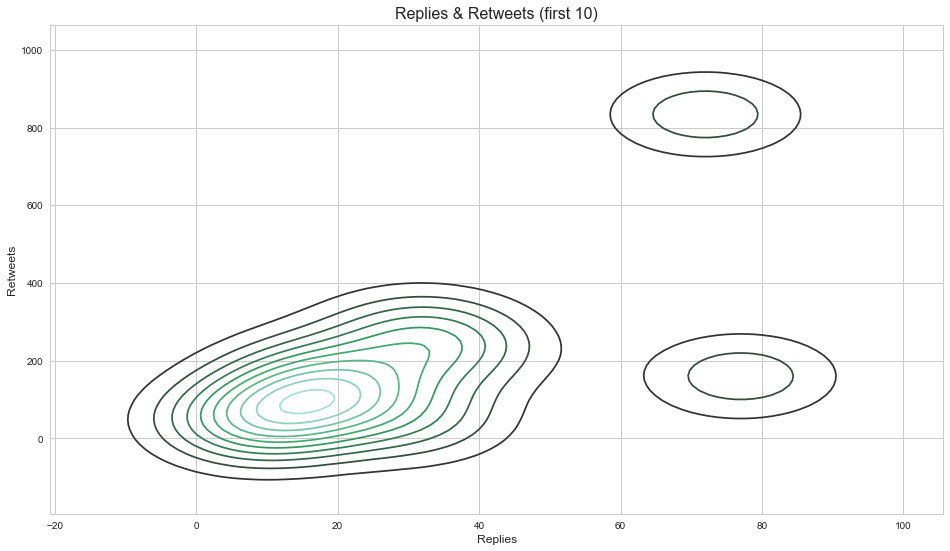

In [8]:
# Replies-Retweets
plt.figure(figsize=(16, 9))
sns.kdeplot(tweets.replies[:10].dropna(), tweets.retweets[:10].dropna())
plt.title('Replies & Retweets (first 10)', fontsize=16)
plt.xlabel('Replies', fontsize=12)
plt.ylabel('Retweets', fontsize=12)

Text(0,0.5,'Retweets')

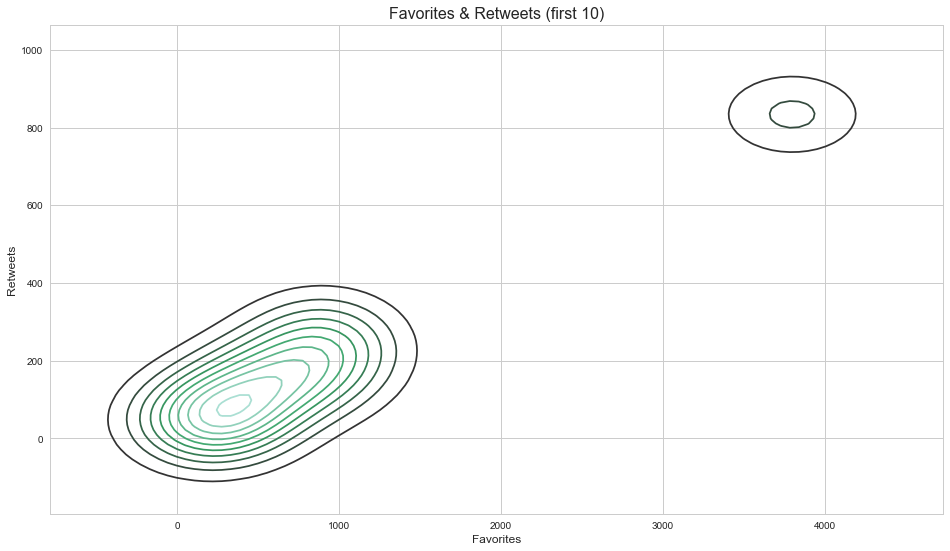

In [9]:
# Favourites-Retweets
plt.figure(figsize=(16, 9))
sns.kdeplot(tweets.favorites[:10].dropna(), tweets.retweets[:10].dropna())
plt.title('Favorites & Retweets (first 10)', fontsize=16)
plt.xlabel('Favorites', fontsize=12)
plt.ylabel('Retweets', fontsize=12)

Text(0,0.5,'Favorites')

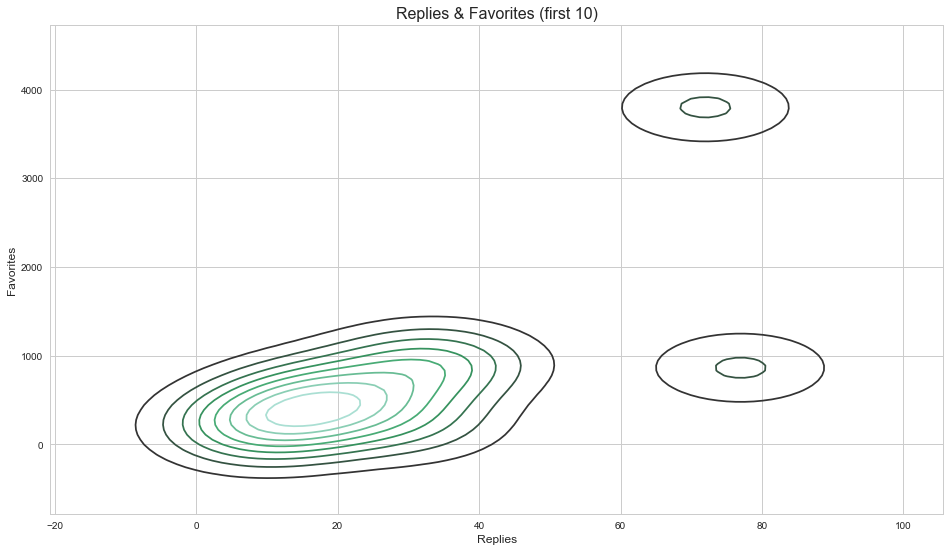

In [10]:
# Replies-Favorites
plt.figure(figsize=(16, 9))
sns.kdeplot(tweets.replies[:10].dropna(), tweets.favorites[:10].dropna())
plt.title('Replies & Favorites (first 10)', fontsize=16)
plt.xlabel('Replies', fontsize=12)
plt.ylabel('Favorites', fontsize=12)

Text(0.5,0,'Count')

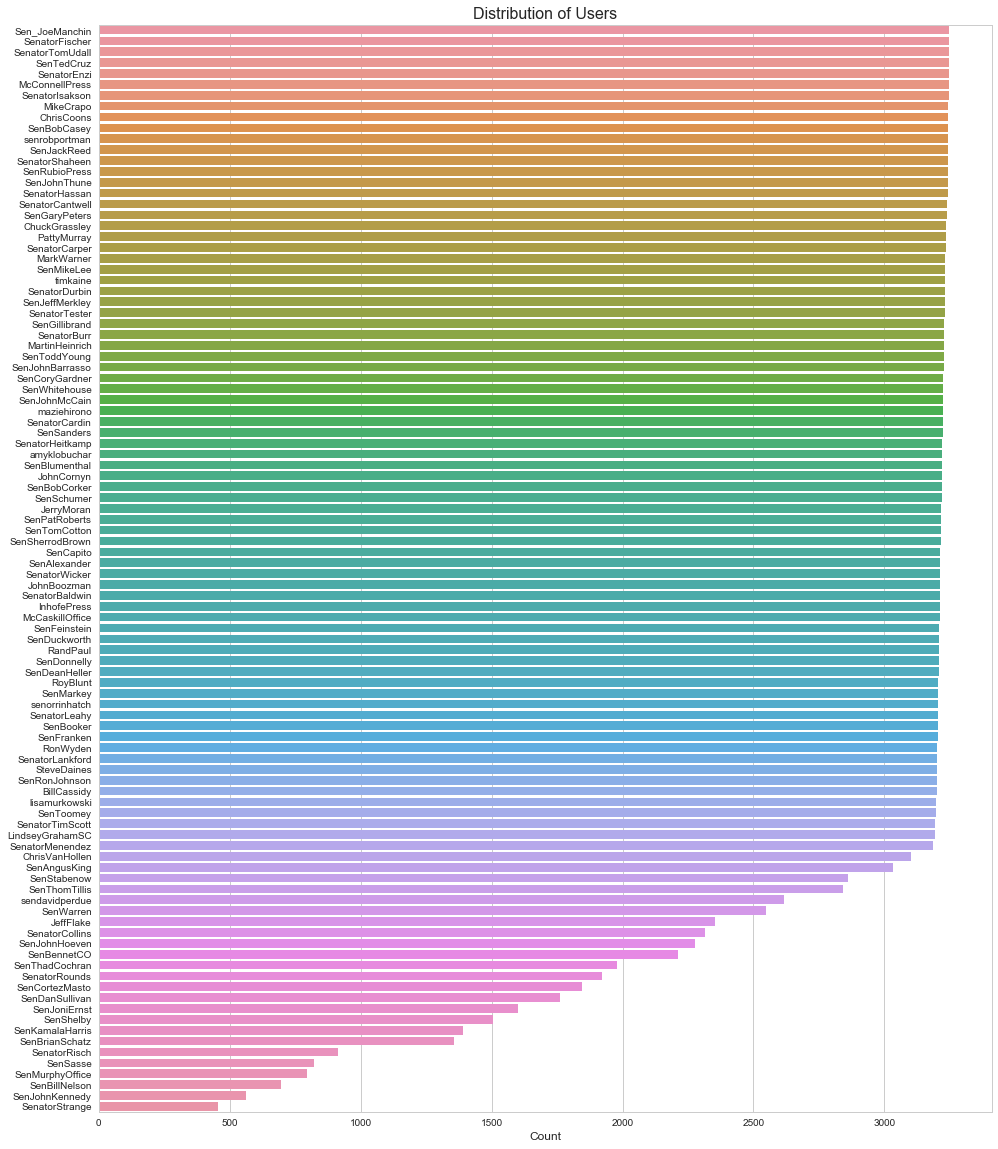

In [11]:
# Distribution of users
plt.figure(figsize=(16, 20))
sns.countplot(y=tweets.user, order=tweets.user.value_counts().index)
plt.title('Distribution of Users', fontsize=16)
plt.ylabel('')
plt.xlabel('Count', fontsize=12)

Text(0.5,0,'Replies')

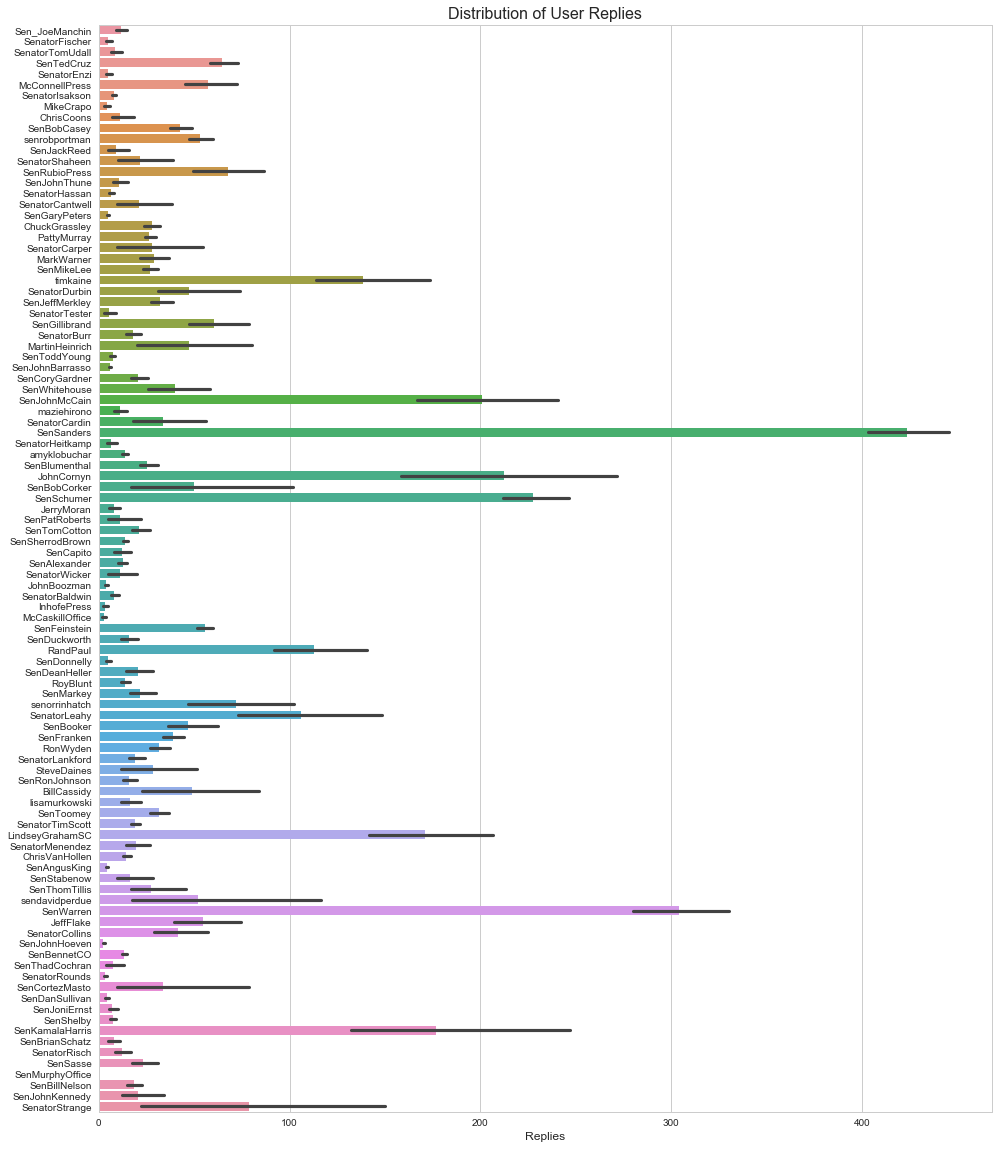

In [12]:
# Distribution of user replies
plt.figure(figsize=(16, 20))
sns.barplot(x=tweets.replies, y=tweets.user, order=tweets.user.value_counts().index)
plt.title('Distribution of User Replies', fontsize=16)
plt.ylabel('')
plt.xlabel('Replies', fontsize=12)

Text(124,0.5,'')

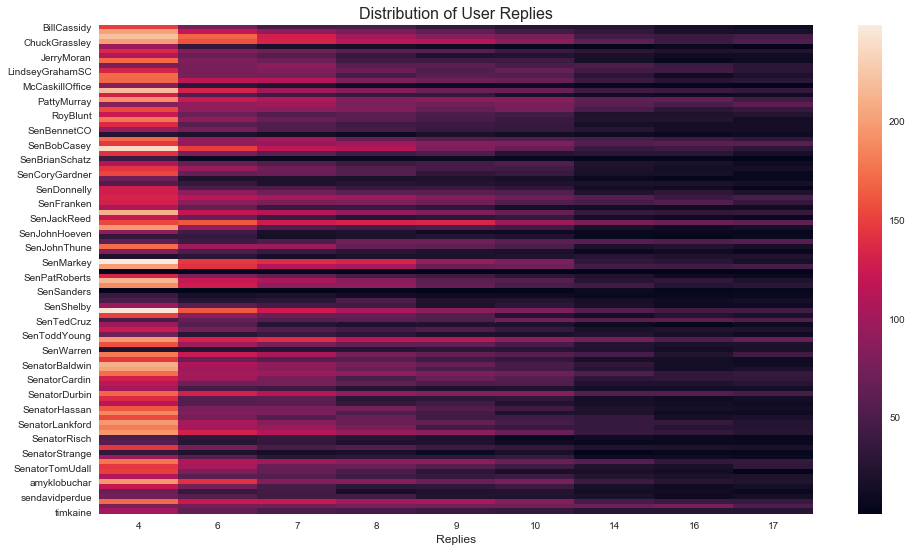

In [13]:
# Distribution of user replies
a = tweets.groupby(['user', 'replies'])['user'].count().unstack('replies').dropna(axis=1, how='any')
plt.figure(figsize=(16, 9))
sns.heatmap(a)
plt.title('Distribution of User Replies', fontsize=16)
plt.xlabel('Replies', fontsize=12)
plt.ylabel('')

Text(124,0.5,'')

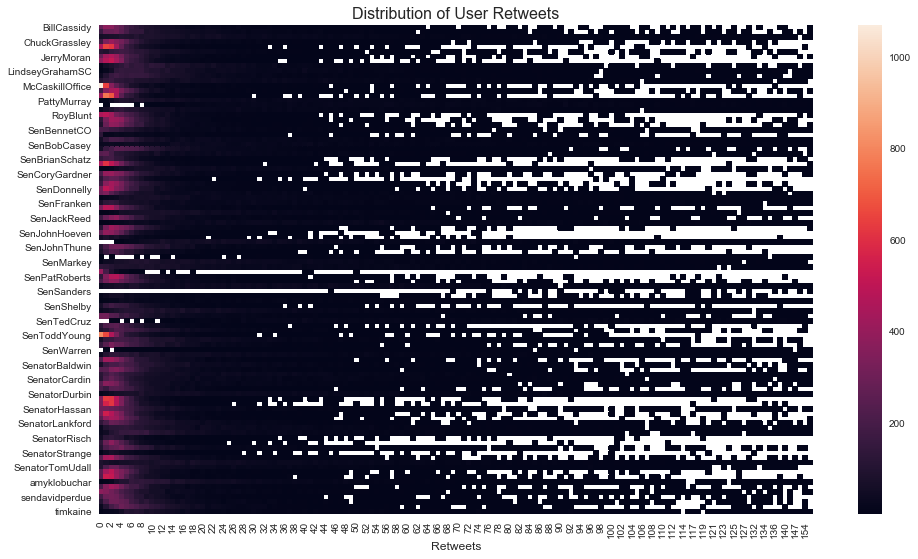

In [14]:
# Distribution of user retweets
a = tweets.groupby(['user', 'retweets'])['user'].count().unstack('retweets').dropna(axis=1, how='all')

# Cleaning the matrix
_removeColumn = list()
for column in a.columns:
    # 1. Number of unique items the columns contains:
    if (len(a[column].unique()) == 1):
        _removeColumn.append(column)
        # 2. Number of missing values:
    elif (a[column].isnull().sum() > ((a.shape[0])/2)):
        _removeColumn.append(column)

# Removing the columns
deleteColumn = (x for x in _removeColumn)
try:
    while True:
        del a[deleteColumn.__next__()]
except StopIteration:
    pass

# Plotting
plt.figure(figsize=(16, 9))
sns.heatmap(a)
plt.title('Distribution of User Retweets', fontsize=16)
plt.xlabel('Retweets', fontsize=12)
plt.ylabel('')

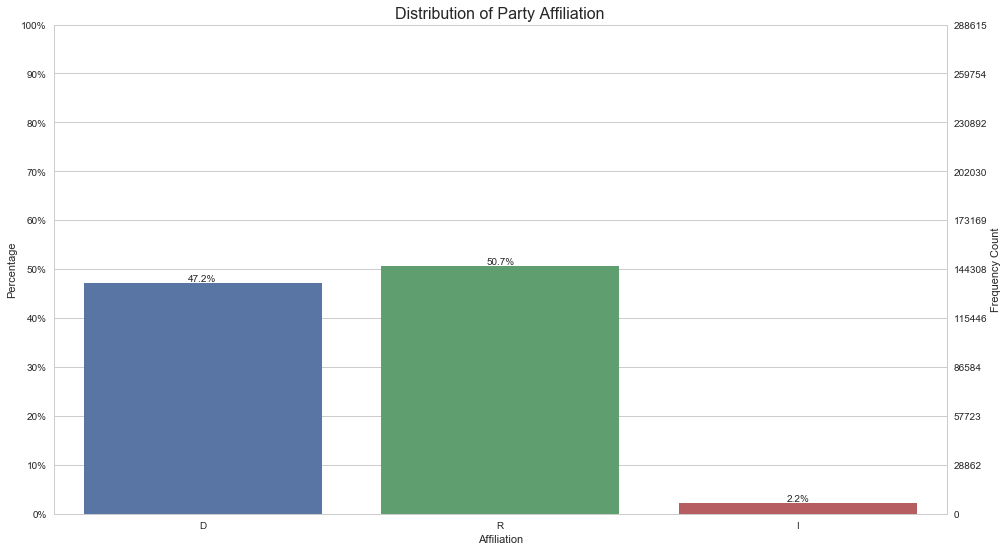

In [15]:
# Distribution of party affiliations
clr.frequency_plot(dataframe=tweets, 
                   x='party',
                   title='Distribution of Party Affiliation',
                   xlabel='Affiliation')

Text(0,0.5,'Count')

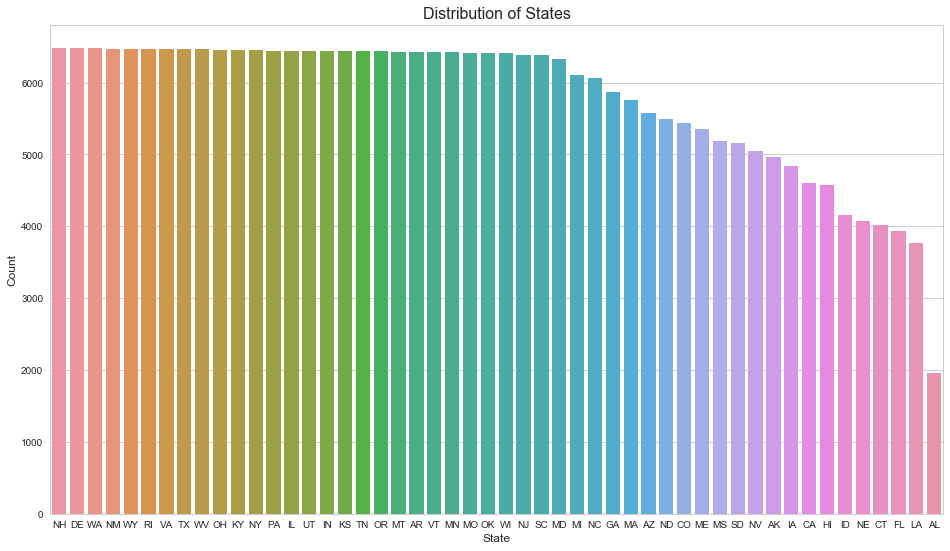

In [16]:
# Distribution of states
sns.countplot(tweets.state, order=tweets.state.value_counts().index)
plt.title('Distribution of States', fontsize=16)
plt.xlabel('State', fontsize=12)
plt.ylabel('Count', fontsize=12)

(array([  0.5,   2.5,   4.5,   6.5,   8.5,  10.5,  12.5,  14.5,  16.5,
         18.5,  20.5,  22.5,  24.5,  26.5,  28.5,  30.5,  32.5,  34.5,
         36.5,  38.5,  40.5,  42.5,  44.5,  46.5,  48.5]),
 <a list of 25 Text yticklabel objects>)

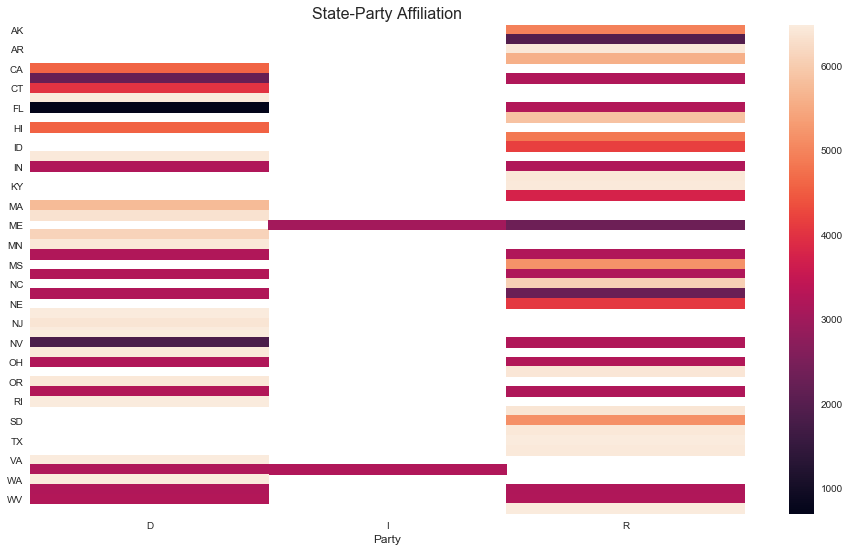

In [17]:
# State-Party
a = tweets.groupby(['state', 'party'])['state'].count().unstack('party')
sns.heatmap(a)
plt.title('State-Party Affiliation', fontsize=16)
plt.xlabel('Party', fontsize=12)
plt.ylabel('')
plt.yticks(rotation=0)

(array([  0.5,   2.5,   4.5,   6.5,   8.5,  10.5,  12.5,  14.5,  16.5,
         18.5,  20.5,  22.5,  24.5,  26.5,  28.5,  30.5,  32.5,  34.5,
         36.5,  38.5,  40.5,  42.5,  44.5,  46.5,  48.5]),
 <a list of 25 Text yticklabel objects>)

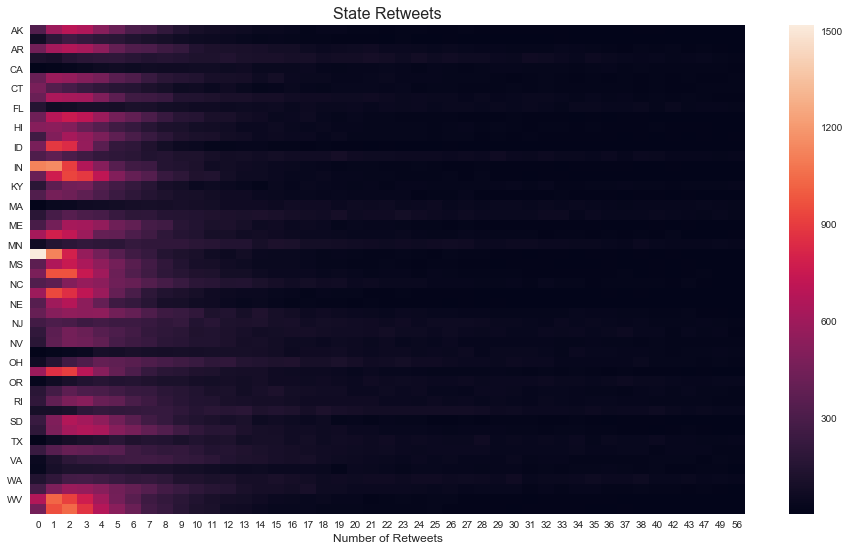

In [18]:
# State-Retweets
a = tweets.groupby(['state', 'retweets'])['retweets'].count().unstack('retweets').dropna(axis=1, how='any')
sns.heatmap(a)
plt.title('State Retweets', fontsize=16)
plt.xlabel('Number of Retweets', fontsize=12)
plt.ylabel('')
plt.yticks(rotation=0)

(array([  0.5,   2.5,   4.5,   6.5,   8.5,  10.5,  12.5,  14.5,  16.5,
         18.5,  20.5,  22.5,  24.5,  26.5,  28.5,  30.5,  32.5,  34.5,
         36.5,  38.5,  40.5,  42.5,  44.5,  46.5,  48.5]),
 <a list of 25 Text yticklabel objects>)

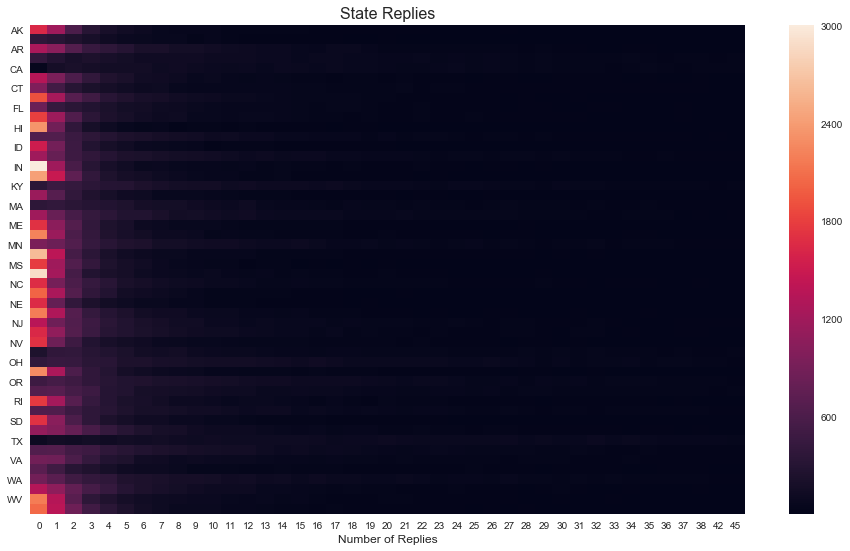

In [19]:
# State-Replies
a = tweets.groupby(['state', 'replies'])['replies'].count().unstack('replies').dropna(axis=1, how='any')
sns.heatmap(a)
plt.title('State Replies', fontsize=16)
plt.xlabel('Number of Replies', fontsize=12)
plt.ylabel('')
plt.yticks(rotation=0)

### Time Series

In [20]:
# Converting 'created_at' to datetime format
tweets['created_at'] = pd.to_datetime(tweets['created_at'], yearfirst=True, exact=False)

# Subsetting
tweets_subset = tweets.loc[(tweets['created_at'].dt.year > 2015)]
tweets_subset = tweets_subset.sort_values(by='created_at')

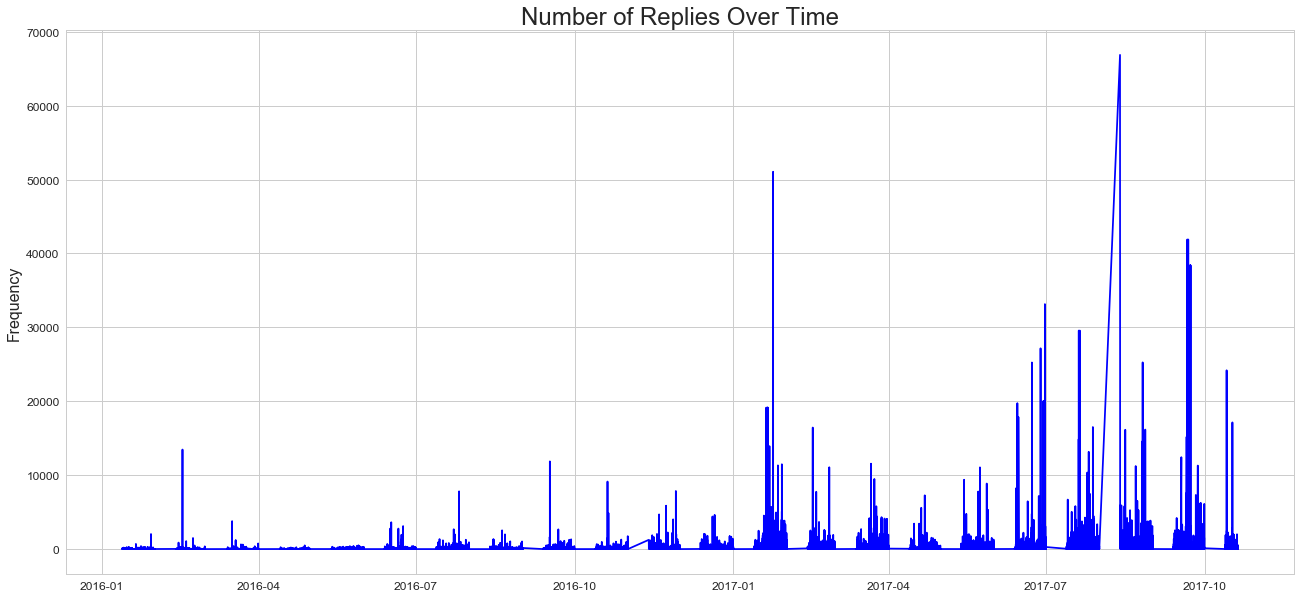

In [21]:
# Plotting function
def plot_series(series, title=None, color='blue'):
    plt.figure(figsize=(22, 10))
    plt.plot(series, color=color)
    plt.title(title, fontsize=24)
    plt.xticks(fontsize=12)
    plt.ylabel('Frequency', fontsize=16)
    plt.yticks(fontsize=12)

# Creating the tweet replies series
s = tweets_subset[['created_at', 'replies']]
replies = s.set_index('created_at')['replies']

# Number of tweet replies over time
plot_series(replies, title='Number of Replies Over Time')

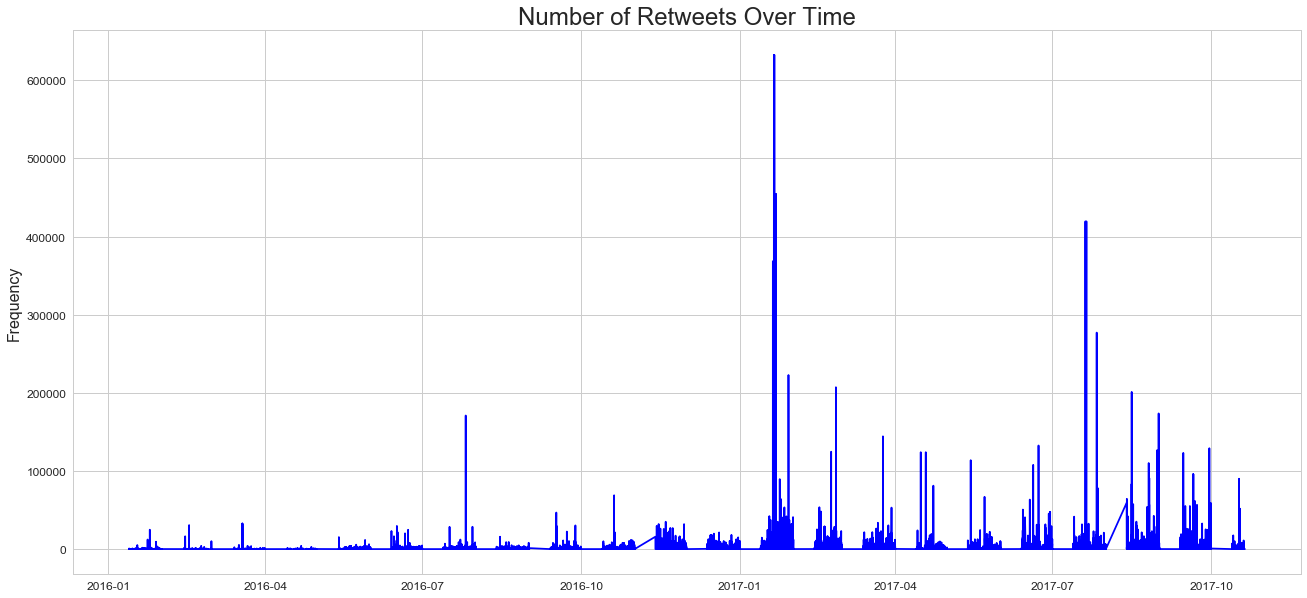

In [22]:
# Creating the retweet series
s = tweets_subset[['created_at', 'retweets']]
retweets = s.set_index('created_at')['retweets']

# Number of retweets over time
plot_series(retweets, title='Number of Retweets Over Time')

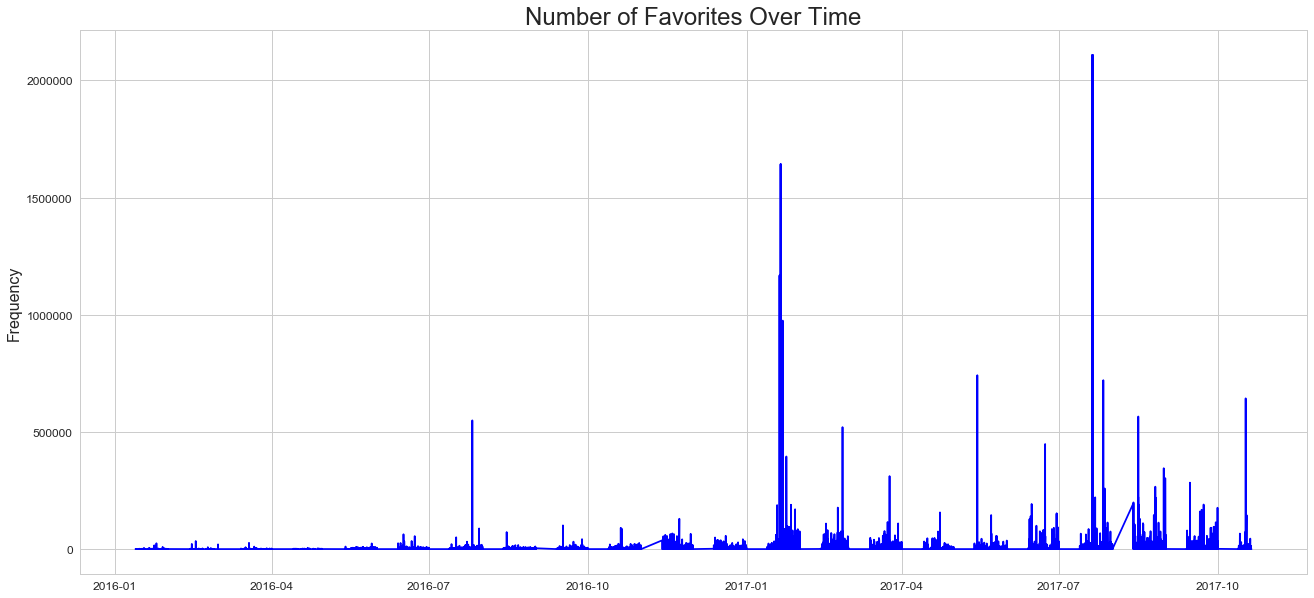

In [23]:
# Creating the favorites series
s = tweets_subset[['created_at', 'favorites']]
favorites = s.set_index('created_at')['favorites']

# Number of retweets over time
plot_series(favorites, title='Number of Favorites Over Time')

### Text Analysis

In [24]:
# Text corpus
document = [i for i in tweets.text]

# Removing common words and tokenizing
stop_words = set(stopwords.words('english'))
update_words = ['-', '=', '+', '*','.', ',', '"', "'", '?', '!', 'w/',
                ':', ';', 'heäó»ll', "i'd", '(and', "there's", '(', 
                ')', '[', ']', '{', '}', '&amp', '&amp;', '&', '$', 
                '^', '.*', '*.', 'äóìbest', 'adäó_', 'staäó_', "i'll",
                'worldäó_', 'hereäó»s', 'letäó»s', 'adminäó»s', '(who', 
                'haveäó_', 'äóñ', '--', '---', 'träó_', 'americaäó»s', 
                'andäó_', 'foräó_', 'cräó_', 'asäó_', 'täó_', 'wäó_', 
                'toäó_', "it'll", "i've", 'iäó»ll', 'here:', ':here',
                'https:äó_', 'httpsäó_']
stop_words.update(update_words)
for doc in document:
    list_of_words = [i.lower() for i in wordpunct_tokenize(doc) if i.lower() not in stop_words]
stop_words.update(list_of_words)

# Removing common words
texts = [[word for word in doc.lower().split() if word not in stop_words] for doc in document]

# Removing words that appear only once
frequency = defaultdict(int)
for text in texts:
    for token in text:
        frequency[token] += 1
texts = [[token for token in text if frequency[token] > 7] for text in texts]

# Create dictionary of the document
dictionary = corpora.Dictionary(texts)
dictionary.save('senator.dict')

# Converting document to a vector (bag-of-words)
corpus = [dictionary.doc2bow(text) for text in texts]
corpora.MmCorpus.serialize('senator.mm', corpus)

# Print done
print('Done!')

Done!


***
#### Transformation: _Term Frequency - Inverse Document Frequency (TF-IDF)_

**tf-idf** is initialized with a **bag-of-words** (integer values) training corpus and takes in a vector, returning another vector of the same dimensionality. except that features which are rare in the training corpus will have their value increased. It therefore converts integer-valued vectors into real-valued ones, while leaving the number of dimensions intact. It can also, optionally, normalize the resulting vectors to (Euclidean) unit length.

##### Step 1:

In [25]:
# Initialization
tfidf = models.TfidfModel(corpus)

##### Step 2:

In [26]:
# Applying the transformation to the whole corpus
corpus_tfidf = tfidf[corpus]

#### Transformation: _Latent Semantic Indexing (LSI, or sometimes LSA)_

Transforms documents from either **bag-of-words** or (preferably) **tf-idf**-weighted space into a latent space of a lower dimensionality. 

**LSI** is unique in that we can continue "training" at any point, simply by providing more training documents. This is done by incremental updates to the underlying model, in a process called _online training_. Because of this feature, the input document stream may even be infinite - just keep feeding **LSI** new documents as they arrive, while using the computed transformation model as read-only in the meanwhile!

[gensim.models.lsimodel](https://radimrehurek.com/gensim/models/lsimodel.html#module-gensim.models.lsimodel) contains details for making an **LSI** model gradually "forget" old observations in infinite streams, with parameters that can be tweaked to affect speed, memory footprint and numerical precision of the **LSI** algorithm.

[___gensim___](https://radimrehurek.com/gensim) uses a novel online incremental streamed distributed training algorithm published [here](https://radimrehurek.com/gensim/tut2.html#id10). ___gensim___ also executes a stochastic multi-pass algorithm from [Halko et al.](https://radimrehurek.com/gensim/tut2.html#id9) internally, to accelerate in-core part of the computations.

In [27]:
# Initializing an LSI transformation
lsi = models.LsiModel(corpus_tfidf, id2word=dictionary, num_topics=50)
corpus_lsi = lsi[corpus_tfidf]

In [28]:
lsi.print_topics(10)

[(0,
  '0.304*"rt" + 0.210*"great" + 0.186*"senate" + 0.176*"health" + 0.173*"today" + 0.169*"bill" + 0.150*"care" + 0.131*"thanks" + 0.130*"thank" + 0.124*"help"'),
 (1,
  '-0.530*"great" + 0.337*"health" + 0.298*"care" + -0.253*"thanks" + 0.210*"bill" + 0.192*"senate" + -0.188*"thank" + -0.146*"meeting" + -0.129*"happy" + -0.111*"today"'),
 (2,
  '0.365*"health" + 0.327*"care" + -0.304*"watch" + -0.300*"rt" + -0.296*"senate" + -0.248*"live" + 0.227*"great" + -0.191*"floor" + -0.178*"tune" + -0.163*"hearing"'),
 (3,
  '-0.513*"rt" + -0.364*"thank" + 0.352*"great" + 0.233*"senate" + 0.203*"watch" + -0.178*"happy" + 0.171*"live" + 0.157*"tune" + 0.148*"floor" + 0.138*"health"'),
 (4,
  '-0.470*"rt" + -0.362*"health" + -0.307*"care" + 0.189*"help" + 0.189*"senate" + 0.169*"happy" + -0.161*"thanks" + 0.152*"proud" + 0.147*"bill" + -0.138*"live"'),
 (5,
  '-0.616*"happy" + -0.338*"thank" + -0.258*"birthday" + 0.226*"rt" + -0.192*"health" + -0.169*"care" + -0.146*"watch" + -0.146*"birthday,

| **Top 5 Topics from Latent Semantic Indexing (LSI)** |
| :---: | --- | :---: | --- |
| **1** | _"rt", "great", "senate", "health", "today", "bill", "care", "thanks", "thank", "help"_ | **Description:** | Retweets of tweets related to a health care bill with "thanks" for "help". |
| **2** | _"great", "health", "care", "thanks", "bill", "senate", "thank", "meeting", "happy", "today"_ | **Description:** | Tweets related to health care bill with references to a "happy meeting". |
| **3** | _"health", "care", "watch", "rt", "senate", "live", "great", "floor", "tune", "hearing"_ | **Description:** | Tweets referencing a health care bill & watching or tuning into a live broadcast of a hearing. |
| **4** | _"rt", "thank", "great", "senate", "watch", "happy", "live", "tune", "floor", "health"_ | **Description:** | Retweets with commentary of giving thanks of a live screening related to health. |
| **5** | _"rt", "health", "care", "help", "senate", "happy", "thanks", "proud", "bill", "live"_ | **Description:** | Retweets of tweets related to a health care bill with senate being happy and proud of the bill. |

In [29]:
# Model persistence
lsi.save('senator.lsi')
lsi = models.LsiModel.load('senator.lsi')

***
#### Similarity
##### Step 1:

In [30]:
# Initializing the query structure: transform corpus to LSI space and index it
index = similarities.MatrixSimilarity(lsi[corpus], num_features=50)

# Index persistence
index.save('senator.index')
index = similarities.MatrixSimilarity.load('senator.index')

##### Step 2:

In [31]:
# Performing queries
doc = "Hospital"
vec_bow = dictionary.doc2bow(doc.lower().split())

# Convert the query to LSI spaace
vec_lsi = lsi[vec_bow]

# Perform a similarity query against the corpus
sims = index[vec_lsi]

# Ranking the tweets by their weights of similarity
sims = sorted(enumerate(sims), key=lambda item: -item[1])

# Printing the associated tweets:
for i in range(10):
    print("Tweet Rank #{}:\tWeights {}\nRaw Text: {}\n".format(i+1, sims[i][1], document[sims[i][0]]))

Tweet Rank #1:	Weights 1.0
Raw Text: Very clever bedpan art! @PHXChildrens Hospital https://t.co/G8gLKBSRFd

Tweet Rank #2:	Weights 0.8245710134506226
Raw Text: #KansasCommonSense: Touring @WichitaState's NIAR, Bonner Springs @Rotary Club, roundtable w/ hospital admins and more http://t.co/Aaomf7k3Tw

Tweet Rank #3:	Weights 0.8210892677307129
Raw Text: Guthrie Center HS 225ppl TOPICS-guns, urban sprawl, deficit,IAsenators, farms, vets jobs,Immig, mental health, drugs, GMOs #99countymeetings

Tweet Rank #4:	Weights 0.814704179763794
Raw Text: Toured Hagie mfg. In wright co. 55 employees asked abt:corp tax,high value of dollar,# 1äó_ https://t.co/15STugNGG7

Tweet Rank #5:	Weights 0.8144620656967163
Raw Text: Talked about the issues our manufacturers face on my tour of the Plastic Professionals in Cass County. #99CountyTour https://t.co/Zha63TlfJ2

Tweet Rank #6:	Weights 0.799569308757782
Raw Text: Tour &amp; q+a with employees at Toyota Financial Services in CR. 64+ ppl Qs on daily sche

#### Transformation:  _Latent Dirichlet Allocation (LDA)_

**LDA** is a transformation from **bag-of-words** counts into a topic space of lower dimensionality. **LDA** is an extension of **LSA** (also called ___multinomial PCA___), so **LDA**'s topics can be interpreted as probability distributions over words. These distributions are, just like with **LSA**, inferred automatically from a training corpus. Documents are in turn interpreted as a (soft) mixture of these topics (just like **LSA**).

In [32]:
# Batch LDA: extract 50 LDA topics, using 1 pass updating once every chunk (10,000 documents)
lda = models.ldamodel.LdaModel(corpus, id2word=dictionary, num_topics=50, update_every=1, passes=1, chunksize=10000)

# Model persistance
lda.save('senator.lda')
lda = models.ldamodel.LdaModel.load('senator.lda')

In [33]:
# Top contributing words for 10 randomly selected topics
lda.print_topics(10)

[(19,
  '0.051*"right" + 0.025*"@marcorubio" + 0.020*"long" + 0.018*"signed" + 0.017*"communities" + 0.017*"now." + 0.015*"@senpatroberts" + 0.014*"rt" + 0.013*"things" + 0.013*"historic"'),
 (3,
  '0.015*"mr." + 0.014*"rt" + 0.013*"nothing" + 0.013*"us" + 0.012*"become" + 0.011*"toward" + 0.011*"behind" + 0.011*"anyone" + 0.010*"actions" + 0.010*"fought"'),
 (42,
  '0.096*"happy" + 0.030*"birthday" + 0.025*"helping" + 0.022*"arkansas" + 0.022*"celebrating" + 0.019*"rt" + 0.018*"https://t.äó_" + 0.014*"thank" + 0.013*"grant" + 0.011*"#tbt"'),
 (47,
  '0.028*"letter" + 0.023*"another" + 0.020*"it." + 0.020*"tour" + 0.020*"calling" + 0.015*"well" + 0.013*"#iran" + 0.013*"set" + 0.013*"sent" + 0.013*"yet"'),
 (12,
  '0.120*"rt" + 0.045*"@stevedaines" + 0.020*"senator" + 0.018*"defense" + 0.017*"https:/äó_" + 0.015*"award" + 0.015*"receive" + 0.014*"https://täó_" + 0.013*"sen." + 0.012*"key"'),
 (0,
  '0.041*"county" + 0.029*"today!" + 0.019*"todayäó»s" + 0.019*"press" + 0.018*"visiting" +

| **Top 5 Randomly Selected Topics from Latent Dirichlet Allocation (LDA)** |
| :---: | --- | :---: | --- |
| **19** | _"right", "@marcorubio", "long", "signed", "communities", "now.", "@senpatroberts", "rt", "things", "historic"_ | **Description:** | Tweets related to the right mentioning [Marco Rubio](https://en.wikipedia.org/wiki/Marco_Rubio) and senator [Pat Roberts](https://en.wikipedia.org/wiki/Pat_Roberts) with retweets references to historic events and communities. |
| **42** | _"mr.", "rt", "nothing", "us", "become", "toward", "behind", "anyone", "actions", "fought"_ | **Description:** | Topic 43 (index is 0) does not seem to have a coherent topic of reference.* |
| **47** | _"happy", "birthday", "helping", "arkansas", "celebrating", "rt", "https://t.äó_", "thank", "grant", "#tbt"_ | **Description:** | Topic 48 contains birthday celebration references with the hashtag "#tbt" (Throw-Back-Thursday or is it Tuesday?). |
| **12** | _"rt", "@stevedaines", "senator", "defense", "https:/äó_", "award", "receive", "https://täó_", "sen.", "key"'_ | **Description:** | This topic references retweets with mentions of senator [Steve Daines](https://en.wikipedia.org/wiki/Steve_Daines), receiving a defense awared. |
| **0** | _"county", "today!", "todayäó»s", "press", "visiting", "conference", "rt", "past", "following", "ohioans"_ | **Description:** | Tweets related to a county in Ohio with press conference news retweets.* |

### Conclusion

At this point, we observe that **LDA** provides topic models with better coherent semantic reference compared to **LDA**, which seems to contain words with a hidden reference.